  # Test of hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight

  ### Definition of names for plots and files

In [2]:
morethan5 = False

extragalactic = False
galactic = False

date = '20200109'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v5.1/dfcrossmatches_prioritized_v5.1.csv'
#detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
#features_file = '../alerce_trainingset/training_set_v3/features.pkl'
features_file = '../ZTF_data/features_20200109_with_preliminary_WISE.csv'

featues_SN_augmented = '../GP_augmentation/augmented_features_20200109.pkl'
#labels_SN_augmented = '../GP_augmentation/augmented_labels.pkl'


class_output = '../ZTF_classifications/classification_unlabelled_set_with_TSvs5_'+date+'.csv'

#where the RF models are saved
if morethan5:
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_morethan5gr_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_morethan5gr_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_morethan5gr_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_morethan5gr_'+date

else: 
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_'+date

#confusion matrixes
if morethan5:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_morethan5gr_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_morethan5gr_'+date

else:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances
if morethan5:
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_morethan5gr_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_morethan5gr_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_morethan5gr_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_morethan5gr_'+date
    
else: 
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_'+date

### reading the training set files 

In [3]:
#df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')

df_featues_SN_augmented = pd.read_pickle(featues_SN_augmented)

oids_drop = ['ZTF18abfwuwn', 'ZTF19aaruixj', 'ZTF18abgxvra' ,'ZTF19aaezwmr', 'ZTF19aapwnmb', 'ZTF19aapcvxi' ,'ZTF19aaeicsm' , 'ZTF18abesqnb', 'ZTF18acxgqxq' ,'ZTF18acqyvag', 'ZTF19aaoaaap', 'ZTF18aczbgpm','ZTF19aahsnmq']
#df_labels_SN_augmented = pd.read_pickle(labels_SN_augmented)

df_featues_SN_augmented = df_featues_SN_augmented[df_featues_SN_augmented.index.str.contains('|'.join(oids_drop))==False]


df_labels_SN_augmented = df_featues_SN_augmented.copy()
#df_labels_SN_augmented = df_labels_SN_augmented['classALeRCE']

oids_augmented = set([oid.split("_")[0] for oid in df_labels_SN_augmented.index.unique()]) 
 
print(oids_augmented)

df_featues_SN_augmented = df_featues_SN_augmented.drop('classALeRCE',axis=1)

df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=-999

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'r-W3']=-999
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=-999 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'r-W2']=-999
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=-999 

df_feat['g-W3']=df_feat['Mean_1']-df_feat['W3']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W3']==-999) , 'g-W3']=-999
df_feat.loc[(df_feat['g-W3']>500) | (df_feat['g-W3']<-500) ,'g-W3']=-999 

df_feat['g-W2']=df_feat['Mean_1']-df_feat['W2']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W2']==-999), 'g-W2']=-999
df_feat.loc[(df_feat['g-W2']>500) | (df_feat['g-W3']<-500),'g-W2']=-999

df_featues_SN_augmented['g-W3']=df_featues_SN_augmented['g-r_mean']+df_featues_SN_augmented['r-W3']
df_featues_SN_augmented.loc[(df_featues_SN_augmented['r-W3']==np.nan) |(df_featues_SN_augmented['g-r_mean']==np.nan) | (df_featues_SN_augmented['r-W3']==-999)|(df_featues_SN_augmented['g-r_mean']==-999) , 'g-W3']=-999
df_featues_SN_augmented.loc[(df_featues_SN_augmented['g-W3']>500) | (df_featues_SN_augmented['g-W3']<-500) ,'g-W3']=-999 

df_featues_SN_augmented['g-W2']=df_featues_SN_augmented['g-r_mean']+df_featues_SN_augmented['r-W2']
df_featues_SN_augmented.loc[(df_featues_SN_augmented['r-W2']==np.nan) |(df_featues_SN_augmented['g-r_mean']==np.nan) | (df_featues_SN_augmented['r-W2']==-999)|(df_featues_SN_augmented['g-r_mean']==-999) , 'g-W2']=-999
df_featues_SN_augmented.loc[(df_featues_SN_augmented['g-W2']>500) | (df_featues_SN_augmented['g-W2']<-500) ,'g-W2']=-999 




#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)
df_feat = df_feat.fillna(-999)

df_featues_SN_augmented = df_featues_SN_augmented.replace([np.inf, -np.inf], np.nan)
df_featues_SN_augmented = df_featues_SN_augmented.fillna(-999)

print(df_labels_SN_augmented)
print(df_feat.head())

{'ZTF18ablrljh', 'ZTF18abdfwur', 'ZTF19abfloxk', 'ZTF19abvdgqo', 'ZTF18abktmfz', 'ZTF19abovstj', 'ZTF18acwutbr', 'ZTF19aadgimr', 'ZTF18abvfecb', 'ZTF19aauoulb', 'ZTF19aavhvkd', 'ZTF19aamgttu', 'ZTF18abxbmqh', 'ZTF19aanpcep', 'ZTF18acnnevs', 'ZTF18acqphpd', 'ZTF18abokpvh', 'ZTF18abmmdif', 'ZTF19aawsdlq', 'ZTF19aacwljg', 'ZTF19abhxllw', 'ZTF19abiahik', 'ZTF19abjslyw', 'ZTF19aaqyvdn', 'ZTF19abhjhes', 'ZTF19aamrais', 'ZTF19aanwwlo', 'ZTF19aaqasrq', 'ZTF19abjpntj', 'ZTF19ablojrw', 'ZTF18acszaiy', 'ZTF18acwvcbz', 'ZTF19abnacvf', 'ZTF18acrxppd', 'ZTF19aamggnw', 'ZTF19abbxykm', 'ZTF19aavoweu', 'ZTF18abkhcwl', 'ZTF19abaovea', 'ZTF19aavhblr', 'ZTF19aapreza', 'ZTF19abimzvh', 'ZTF19abgsyrp', 'ZTF18abshezu', 'ZTF19abpnrrf', 'ZTF19aavjzrz', 'ZTF19aampllw', 'ZTF19aafljiq', 'ZTF19aaeopqn', 'ZTF19aapfktd', 'ZTF18aansqun', 'ZTF19abitljz', 'ZTF19abcejrr', 'ZTF18aailmnv', 'ZTF19abjibet', 'ZTF19aarphwc', 'ZTF18acurlbj', 'ZTF19abcekty', 'ZTF19aamhhae', 'ZTF19aanfzox', 'ZTF19abecaca', 'ZTF19aauxxgk', 'ZTF19a

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'EB'
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'EB'

label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph', 'LPV','RSCVn','Periodic-Other']

df_labels_SN_augmented['class_original'] = df_labels_SN_augmented['classALeRCE']
df_labels_SN_augmented = df_labels_SN_augmented[['class_original','classALeRCE']]
print(df_labels_SN_augmented.head())
df_labels_SN_augmented.loc[(df_labels_SN_augmented['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'

df_labels_SN_augmented = df_labels_SN_augmented.loc[df_labels_SN_augmented.class_original.isin(label_order)][["class_original"]]

df_labels_SN_augmented['class_hierachical'] = df_labels_SN_augmented['class_original']

df_labels_SN_augmented.loc[(df_labels_SN_augmented['class_hierachical'] == 'SNIa') | (df_labels_SN_augmented['class_hierachical'] == 'SNIbc') | (df_labels_SN_augmented['class_hierachical'] == 'SNII') | (df_labels_SN_augmented['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'






#defining the classes included in the RF model
#label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
#               'SLSN', 'EA', 'EB/EW', 'DSCT', 'RRL', 'Ceph', 'LPV','RSCVn','Periodic-Other']


labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]


#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

#labels.loc[(labels['class_hierachical'] == 'RSCVn') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EA') | (labels['class_hierachical'] == 'EB/EW')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'
labels.loc[(labels['class_hierachical'] == 'RSCVn') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EB')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'YSO') | (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'CV/Nova')  |   (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Stochastic','Transient','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
print(df_labels_SN_augmented)

                        class_original classALeRCE
ZTF18aailmnv_augmented0           SNIa        SNIa
ZTF18aailmnv_augmented1           SNIa        SNIa
ZTF18aailmnv_augmented2           SNIa        SNIa
ZTF18aailmnv_augmented3           SNIa        SNIa
ZTF18aailmnv_augmented4           SNIa        SNIa
(170948,)
                        class_original class_hierachical
ZTF18aailmnv_augmented0           SNIa         Transient
ZTF18aailmnv_augmented1           SNIa         Transient
ZTF18aailmnv_augmented2           SNIa         Transient
ZTF18aailmnv_augmented3           SNIa         Transient
ZTF18aailmnv_augmented4           SNIa         Transient
ZTF18aansqun_augmented0           SNIa         Transient
ZTF18aansqun_augmented1           SNIa         Transient
ZTF18aansqun_augmented4           SNIa         Transient
ZTF18abadjhx_augmented0           SNIa         Transient
ZTF18abadjhx_augmented1           SNIa         Transient
ZTF18abadjhx_augmented2           SNIa         Transient


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
#'n_det_1',
#'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'paps_non_zero_1',
'paps_non_zero_1',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',#'W1-W2','W2-W3','g-W2','g-W3','r-W2','r-W3',
]

'''
'dmag_first_det_fid_1',
'dmag_non_det_fid_1',
'last_diffmaglim_before_fid_1',
'last_mjd_before_fid_1',
'max_diffmaglim_before_fid_1',
'median_diffmaglim_before_fid_1',
'n_non_det_before_fid_1',
'n_non_det_after_fid_1',
'max_diffmaglim_after_fid_1',
'median_diffmaglim_after_fid_1',    
'dmag_first_det_fid_2',
'dmag_non_det_fid_2',
'last_diffmaglim_before_fid_2',
'last_mjd_before_fid_2',
'max_diffmaglim_before_fid_2',
'median_diffmaglim_before_fid_2',
'n_non_det_before_fid_2',
'n_non_det_after_fid_2',
'max_diffmaglim_after_fid_2',
'median_diffmaglim_after_fid_2'
'''

rm_nd_cols_SNaug = [
#'n_det_1',
#'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'paps_non_zero_1',
'paps_non_zero_1',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'Mean_1',
'Mean_2',
#'W1-W2','W2-W3','g-W2','g-W3','r-W2','r-W3',
]
'''
'dmag_first_det_fid_1',
'dmag_non_det_fid_1',
'last_diffmaglim_before_fid_1',
'last_mjd_before_fid_1',
'max_diffmaglim_before_fid_1',
'median_diffmaglim_before_fid_1',
'n_non_det_before_fid_1',
'n_non_det_after_fid_1',
'max_diffmaglim_after_fid_1',
'median_diffmaglim_after_fid_1',    
'dmag_first_det_fid_2',
'dmag_non_det_fid_2',
'last_diffmaglim_before_fid_2',
'last_mjd_before_fid_2',
'max_diffmaglim_before_fid_2',
'median_diffmaglim_before_fid_2',
'n_non_det_before_fid_2',
'n_non_det_after_fid_2',
'max_diffmaglim_after_fid_2',
'median_diffmaglim_after_fid_2'
'''

#print(df_paps.columns)
#paps_drop = ['paps_non_zero_1','paps_PN_flag_1','paps_non_zero_2','paps_PN_flag_2']
#paps_drop = ['paps_non_zero_1','paps_non_zero_2']

wise_drop = ['W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z']

#rm_nd_cols = rm_nd_cols + wise_drop


#combining all the DF
#df = labels.join(df_sgscore).join(df_feat).join(df_nd.drop(rm_nd_cols, axis=1))
#df = labels.join(df_sgscore).join(df_feat.drop(rm_nd_cols, axis=1))

df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')#.join(df_wise.drop(wise_drop, axis=1),how='left')
print(df['g-r_max'].values.size)
#df = df.join(df_wise.drop(wise_drop, axis=1),how='left')
#print(df['g-r_max'].values.size)
df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

df_featues_SN_augmented = df_featues_SN_augmented.drop(rm_nd_cols_SNaug, axis=1)

#print(np.max(df['paps_ratio_2'].values))
#print(len(labels['class_original'].values))
#labels = labels.loc[df.index.values]
print(len(labels['class_original'].values))



print(df['g-r_max'].values.size)
df_labels_SN_augmented.head()

111988
111988
111988
111988


,class_original,class_hierachical
ZTF18aailmnv_augmented0,SNIa,Transient
ZTF18aailmnv_augmented1,SNIa,Transient
ZTF18aailmnv_augmented2,SNIa,Transient
ZTF18aailmnv_augmented3,SNIa,Transient
ZTF18aailmnv_augmented4,SNIa,Transient


In [6]:
print(df_featues_SN_augmented.columns)

Index(['Amplitude_1', 'Amplitude_2', 'AndersonDarling_1', 'AndersonDarling_2',
       'Autocor_length_1', 'Autocor_length_2', 'Beyond1Std_1', 'Beyond1Std_2',
       'Con_1', 'Con_2',
       ...
       'positive_fraction_1', 'positive_fraction_2', 'rb', 'sgscore1', 'r-W2',
       'r-W3', 'W1-W2', 'W2-W3', 'g-W3', 'g-W2'],
      dtype='object', length=143)


In [7]:
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

QSO 9035
AGN 2147
Blazar 912
CV/Nova 778
YSO 1447
SNIa 765
SNIbc 50
SNII 212
SLSN 20
EB 31943
DSCT 646
RRL 29495
Ceph 553
LPV 32981
RSCVn 755
Periodic-Other 249


  ### Defining functions to plot the confusion matrix and the feature importance

In [8]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [9]:
labels_aux = labels.copy()

#labels_aux = labels_aux.drop(oids_augmented,axis=0)#para GPs va esto

Y_hierarchical = labels_aux['class_hierachical']#.values
Y_original = labels_aux['class_original']#.values

print(len(labels_aux['class_hierachical'].values))
print(len(labels_aux['class_original'].values))
X_hierarchical = df#.columns.values.tolist()
#X_hierarchical = X_hierarchical.drop(oids_augmented,axis=0)#para GPs va esto


#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
#X_train_periodic.drop(['Mean_2'], axis=1,inplace=True)
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

'''#para GPs va esto
X_train_transient = X_train_transient.append(df.loc[oids_augmented])
X_train_transient = X_train_transient.append(df_featues_SN_augmented)

y_train_transient = y_train_transient.append(labels.loc[oids_augmented,'class_original'])
y_train_transient = y_train_transient.append(df_labels_SN_augmented.loc[:,'class_original'])

y_train_hierarchical  = y_train_hierarchical.append(labels.loc[oids_augmented,'class_hierachical'])
y_train_hierarchical  = y_train_hierarchical.append(df_labels_SN_augmented.loc[:,'class_hierachical'])

X_train_hierarchical = X_train_hierarchical.append(df.loc[oids_augmented])
X_train_hierarchical = X_train_hierarchical.append(df_featues_SN_augmented)
'''

X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)


X_train_transient = X_train_transient[X_train_transient.index.str.contains('|'.join(y_test_original.index.values))==False]
X_train_hierarchical = X_train_hierarchical[X_train_hierarchical.index.str.contains('|'.join(y_test_original.index.values))==False]

y_train_transient = y_train_transient[y_train_transient.index.str.contains('|'.join(y_test_original.index.values))==False]
y_train_hierarchical = y_train_hierarchical[y_train_hierarchical.index.str.contains('|'.join(y_test_original.index.values))==False]


df_labels_SN_augmented = df_labels_SN_augmented[df_labels_SN_augmented.index.str.contains('|'.join(y_test_original.index.values))==False]
df_featues_SN_augmented = df_featues_SN_augmented[df_featues_SN_augmented.index.str.contains('|'.join(y_test_original.index.values))==False]

X_train_transient = X_train_transient.append(df_featues_SN_augmented)
y_train_transient = y_train_transient.append(df_labels_SN_augmented.loc[:,'class_original'])

X_train_hierarchical = X_train_hierarchical.append(df_featues_SN_augmented)
y_train_hierarchical = y_train_hierarchical.append(df_labels_SN_augmented.loc[:,'class_original'])




print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))
print(len(y_train_hierarchical),len(X_train_hierarchical['Skew_1'].values))
print(np.amax(X_train_hierarchical['Skew_1'].values))

print(y_train_hierarchical.head())

111988
111988
50912 37840 1917
90669 90669
6.698734790503285
ZTF18abfxgyt      Periodic
ZTF18abdvoll    Stochastic
ZTF18acepife    Stochastic
ZTF18abcqfof    Stochastic
ZTF18ablwppg      Periodic
dtype: object


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


  ## Balanced random forest
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [10]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)

#c = np.c_[y_pred_proba_hier, y_test_original]
#c = np.c_[c, y_pred_]
#print(c)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)

with open(model_first_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_hierarchical,#rf_model_hierarchical,
            'features': features_hierarchical,
            'order_classes': classes_order_proba_hierarchical
            }
        pickle.dump(model_dump, pickle_file)

['Periodic' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'Stochastic' 'Transient']
Accuracy: 0.731002768104295
Balanced accuracy: 0.6965611779230206


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


[[8445  128  850]
 [  80  122    6]
 [4625  266 7806]]
Normalized confusion matrix


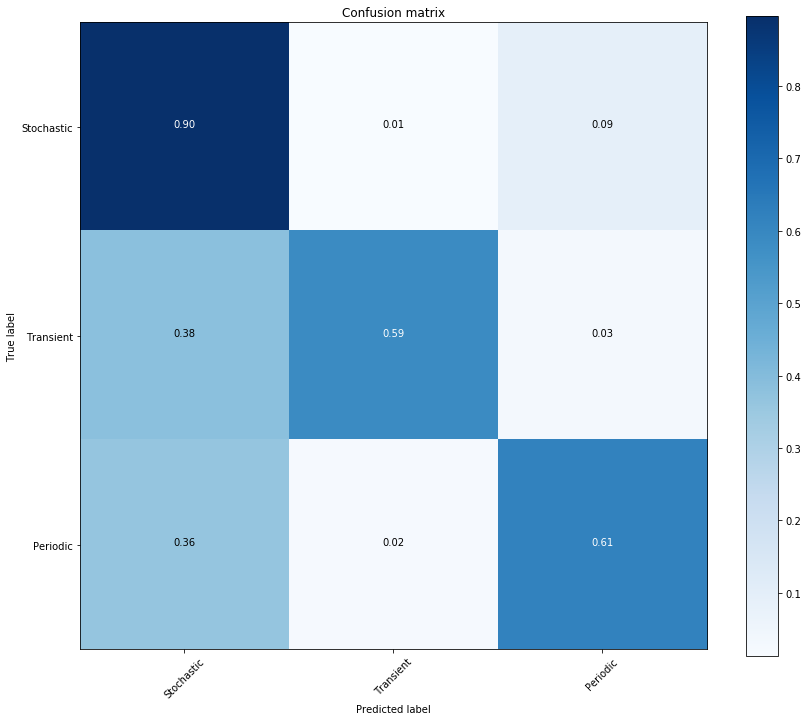

In [11]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,conf_matrix_name_first_layer)

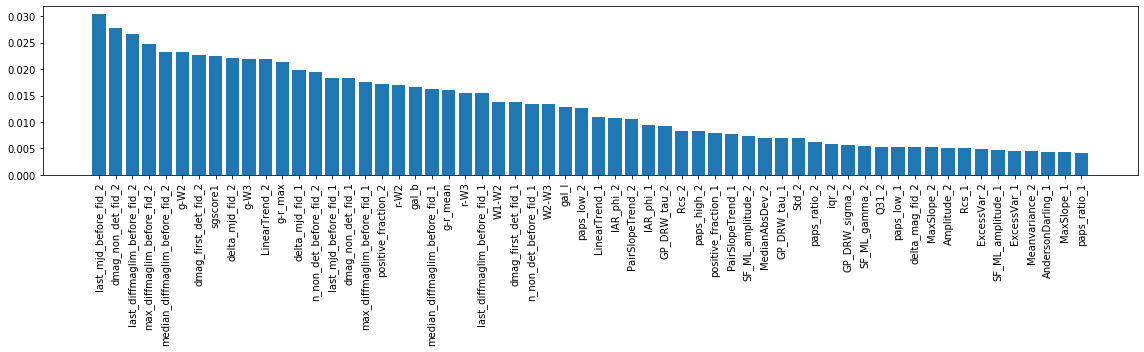

In [12]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, feature_importance_name_first_layer)

  ### Periodic layer

In [13]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            #bootstrap=False,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_periodic,
            'features': features_periodic,
            'order_classes': classes_order_proba_periodic
            }
        pickle.dump(model_dump, pickle_file)

['Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL' 'RSCVn']


82


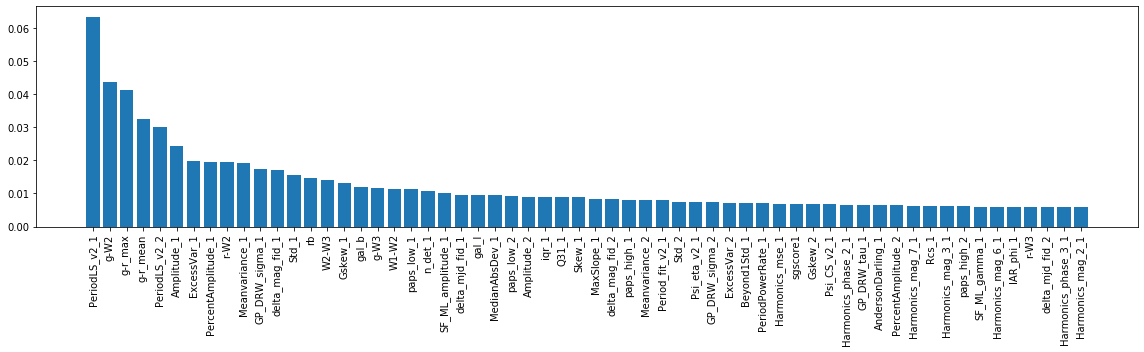

In [14]:
#plotting feature importance
print(len(feature_importance_name_first_layer))
plot_feature_importances(rf_model_periodic, features_periodic, feature_importance_name_periodic_layer)

  ### Stochastic layer

In [15]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_stochastic,
            'features': features_stochastic,
            'order_classes': classes_order_proba_stochastic
            }
        pickle.dump(model_dump, pickle_file)

['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO']


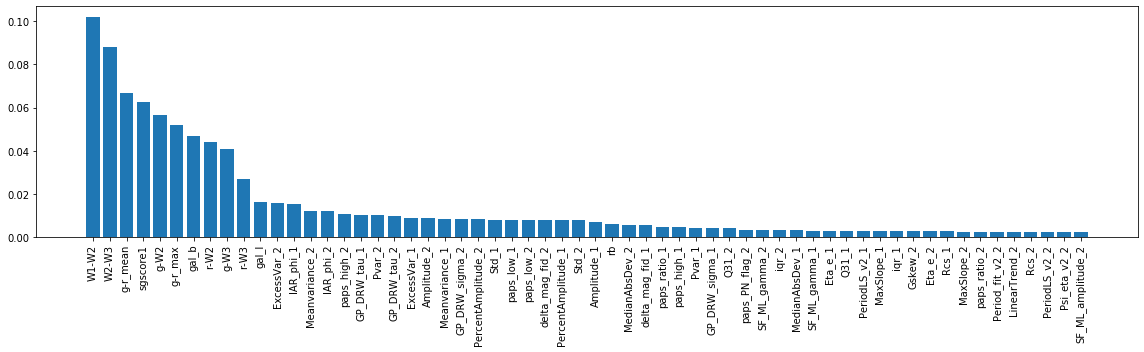

In [16]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, feature_importance_name_stochastic_layer)

  ### Transient layer

In [17]:
#Training Transient layer

print( y_train_transient)

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_transient,
            'features': features_transient,
            'order_classes': classes_order_proba_transient
            }
        pickle.dump(model_dump, pickle_file)

ZTF19abdzehg                SNIa
ZTF18acefuhk                SNII
ZTF18aaqkjuw                SNIa
ZTF19abrirdm                SNIa
ZTF19acftclq               SNIbc
ZTF18aarwxum                SNIa
ZTF19abjgdko                SNIa
ZTF19ababmsi                SNIa
ZTF19aceqxtg                SNIa
ZTF19abajuqh                SNIa
ZTF19aafncsv                SNIa
ZTF19aarfnto                SNIa
ZTF18acrgunw                SNIa
ZTF19aarnqys               SNIbc
ZTF19acftfav                SNII
ZTF19ablusdf                SNIa
ZTF18acbzojv                SNIa
ZTF19aasekcx                SNII
ZTF19abitbcj                SNIa
ZTF18acusbdy                SNIa
ZTF18aczdtgn                SNIa
ZTF19abeytzv                SNIa
ZTF19abvhkst                SNIa
ZTF18abokyfk                SNII
ZTF19abvhduf                SNIa
ZTF19abfiqjg               SNIbc
ZTF19aasmkhn                SNIa
ZTF18abvejqt                SNII
ZTF19aarlefl                SNIa
ZTF19aawbsek                SNIa
          

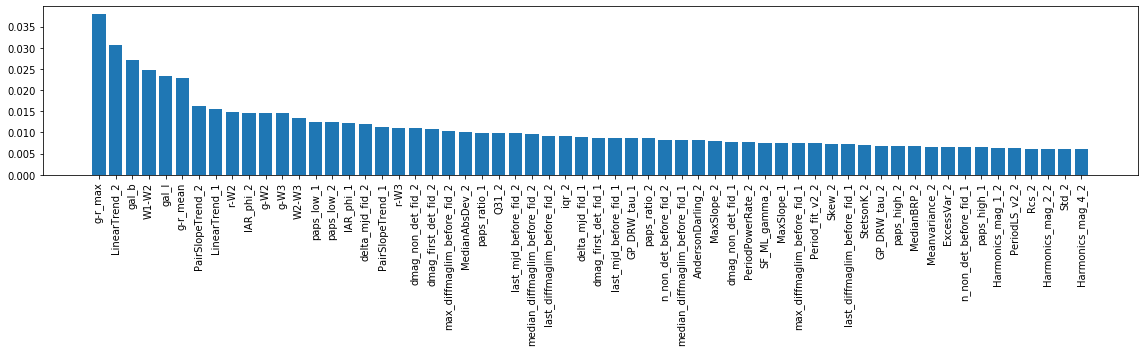

In [18]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, feature_importance_name_transient_layer)

 ## Putting al layers together  


In [19]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[0.616 0.628 0.588 ... 0.656 0.548 0.608] 0.6139356192517188 0.06350675771814449
['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc'
 'Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL' 'RSCVn']


[[1517  202   72    7    2    0    0    1    0    0    0    0    0    0
     1    5]
 [  39  361   18    5    6    1    0    0    0    0    0    0    0    0
     0    0]
 [  27   18  121    4    7    1    0    0    0    0    0    0    0    1
     2    1]
 [   0    0    2  149    2    1    0    0    0    0    1    1    0    0
     0    0]
 [   0    0    4    6  252    0    0    0    0    0    0    0    7    7
    11    2]
 [   0   35    5   83    1   19    2    2    0    0    0    1    0    1
     0    4]
 [   0    1    1    6    0    1    0    1    0    0    0    0    0    0
     0    0]
 [   0   11    1   20    1    3    0    4    0    0    0    0    0    0
     0    2]
 [   0    0    0    4    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    4 4392  252    0    0    0    0 1156  156    7  101    2
   242   77]
 [   0    0    0   78    0    0    0    0    0    2   43    0    0    0
     5    1]
 [   9    2    5 4810   41    2    0    0    0   14   28  896   4

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


weighted F1:  0.5500447190985901


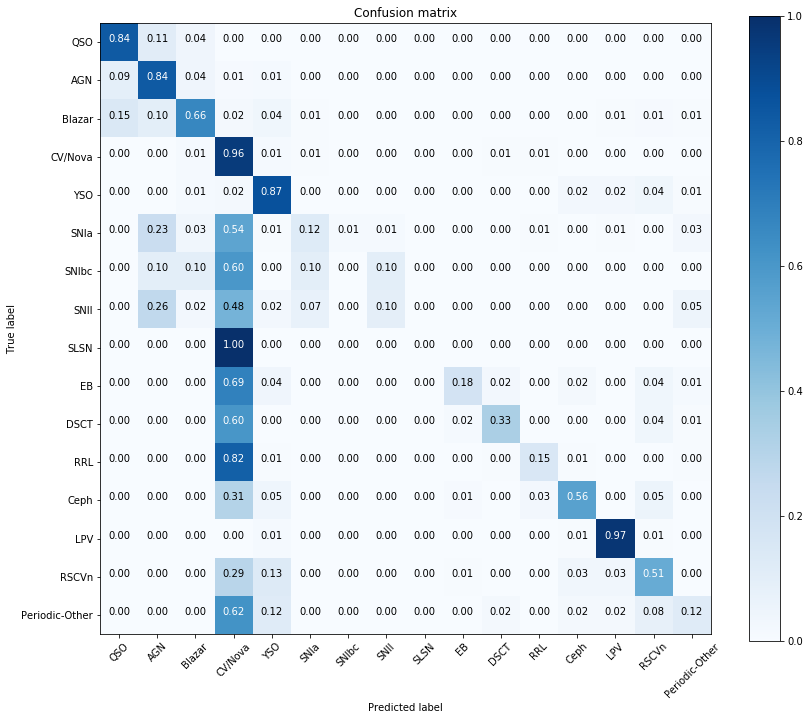

In [20]:
# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, conf_matrix_name_second_layer)

print("Accuracy:", metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, class_final_name))

print("weighted precision: ", metrics.precision_score(y_test_original, class_final_name, average='weighted'))
print("weighted F1: ", metrics.f1_score(y_test_original, class_final_name, average='weighted'))



In [21]:
# Kaggle score

num_y_test =  class_final_index#[np.where(label_order==x)[0][0] for x in y_test_original] #label_encoder.transform(y_test)

class_weights = list(class_weight.compute_class_weight('balanced', label_order, y_test_original))

print(class_weights)

CLASSES_REDUCED_V2 = label_order

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final))

[0.7746956281128943, 3.2555232558139533, 7.6916208791208796, 8.973557692307692, 4.843858131487889, 9.14950980392157, 139.9875, 33.330357142857146, 349.96875, 0.21910705900766944, 10.851744186046512, 0.23730717070689947, 12.611486486486486, 0.21223089751364463, 9.27069536423841, 27.9975]
QSO -0.11464627501024643
AGN -0.12178977487605584
Blazar -0.1138900035880682
CV/Nova -0.08630729995161822
YSO -0.10526627008314027
SNIa -0.11539176307985059
SNII -0.15989524233095817
SLSN -0.15669793253291095
EB -0.16376912754478049
DSCT -0.1115344294083398
RRL -0.11815907961172428
Ceph -0.11658007913699264
LPV -0.1337178955230178
RSCVn -0.10831006303710179


IndexError: index 15 is out of bounds for axis 0 with size 15

In [ ]:
#print(class_final_name)

df_test = labels.join(X_test_hierarchical[['n_det_1','n_det_2']],how='right')

df_test = df_test.join(df_feat[['Mean_1','Mean_2']],how='left')

df_test['predicted_class'] = class_final_name

df_test_1band = df_test.loc[(df_test['n_det_1']<6) | (df_test['n_det_2']<6)]

df_test_2band = df_test.loc[(df_test['n_det_1']>=6) & (df_test['n_det_2']>=6)]

print(df_test_2band.head())

In [ ]:
bins_mag = np.arange(12.5,22,0.5)
bins_nsamp_1band = np.arange(20,501,20)
bins_nsamp_2band = np.arange(20,831,20)

#1 band
acc_mag_1band_stochastic=[]
acc_mag_1band_periodic=[]
acc_mag_1band_transient=[]

for i in range(len(bins_mag)):
    df_test_1band_aux = df_test_1band[((df_test_1band['Mean_1']>=(bins_mag[i]-0.25)) & (df_test_1band['Mean_1']<(bins_mag[i]+0.25))) | ((df_test_1band['Mean_2']>=(bins_mag[i]-0.25)) & (df_test_1band['Mean_2']<(bins_mag[i]+0.25)))]
    
    #stochastics:
    df_test_1band_aux_stochastic = df_test_1band_aux[df_test_1band_aux['class_hierachical']=='Stochastic']
    true_y_stochastic = df_test_1band_aux_stochastic['class_original'].values
    pred_y_stochastic = df_test_1band_aux_stochastic['predicted_class'].values
    acc_stochastic = metrics.balanced_accuracy_score(true_y_stochastic, pred_y_stochastic)
    acc_mag_1band_stochastic.append(acc_stochastic)
    
    #periodics
    df_test_1band_aux_periodic = df_test_1band_aux[df_test_1band_aux['class_hierachical']=='Periodic']
    true_y_periodic = df_test_1band_aux_periodic['class_original'].values
    pred_y_periodic = df_test_1band_aux_periodic['predicted_class'].values
    acc_periodic = metrics.balanced_accuracy_score(true_y_periodic, pred_y_periodic)
    acc_mag_1band_periodic.append(acc_periodic)
    
    #transients
    df_test_1band_aux_transient = df_test_1band_aux[df_test_1band_aux['class_hierachical']=='Transient']
    true_y_transient = df_test_1band_aux_transient['class_original'].values
    pred_y_transient = df_test_1band_aux_transient['predicted_class'].values
    acc_transient = metrics.balanced_accuracy_score(true_y_transient, pred_y_transient)
    acc_mag_1band_transient.append(acc_transient)

acc_mag_1band_stochastic=np.array(acc_mag_1band_stochastic)
acc_mag_1band_periodic=np.array(acc_mag_1band_periodic)
acc_mag_1band_transient=np.array(acc_mag_1band_transient)

print(acc_mag_1band_stochastic)



plt.plot(bins_mag,acc_mag_1band_stochastic,'ro-',label='Stochastic')
plt.plot(bins_mag,acc_mag_1band_periodic,'bo-',label='Periodic')
plt.plot(bins_mag,acc_mag_1band_transient,'go-',label='Transient')
plt.legend()
plt.xlabel('mean mag')
plt.ylabel('Balanced Accuracy')

In [ ]:
#2 bands
acc_mag_2band_stochastic=[]
acc_mag_2band_periodic=[]
acc_mag_2band_transient=[]

mag_2band_stochastic=[]
mag_2band_periodic=[]
mag_2band_transient=[]

for i in range(len(bins_mag)):
    df_test_2band_aux = df_test_2band[((df_test_2band['Mean_2']>=(bins_mag[i]-0.25)) & (df_test_2band['Mean_2']<(bins_mag[i]+0.25)))]
    #stochastics:
    df_test_2band_aux_stochastic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Stochastic']
    true_y_stochastic = df_test_2band_aux_stochastic['class_original'].values
    pred_y_stochastic = df_test_2band_aux_stochastic['predicted_class'].values
    acc_stochastic = metrics.balanced_accuracy_score(true_y_stochastic, pred_y_stochastic)
    acc_mag_2band_stochastic.append(acc_stochastic)
    
    #periodics
    df_test_2band_aux_periodic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Periodic']
    true_y_periodic = df_test_2band_aux_periodic['class_original'].values
    pred_y_periodic = df_test_2band_aux_periodic['predicted_class'].values
    acc_periodic = metrics.balanced_accuracy_score(true_y_periodic, pred_y_periodic)
    acc_mag_2band_periodic.append(acc_periodic)
    
    #transients
    df_test_2band_aux_transient = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Transient']
    print(len(df_test_2band_aux_transient['n_det_1'].values),bins_mag[i])
    true_y_transient = df_test_2band_aux_transient['class_original'].values
    pred_y_transient = df_test_2band_aux_transient['predicted_class'].values
    acc_transient = metrics.balanced_accuracy_score(true_y_transient, pred_y_transient)
    acc_mag_2band_transient.append(acc_transient)

acc_mag_2band_stochastic=np.array(acc_mag_2band_stochastic)
acc_mag_2band_periodic=np.array(acc_mag_2band_periodic)
acc_mag_2band_transient=np.array(acc_mag_2band_transient)

print(acc_mag_1band_stochastic)

plt.plot(bins_mag,acc_mag_2band_stochastic,'ro-',label='Stochastic')
plt.plot(bins_mag,acc_mag_2band_periodic,'bo-',label='Periodic')
plt.plot(bins_mag,acc_mag_2band_transient,'go-',label='Transient')
plt.legend()
plt.xlabel('mean mag')
plt.ylabel('Balanced Accuracy')

In [ ]:
#2 bands
acc_nsamp_2band_stochastic=[]
acc_nsamp_2band_periodic=[]
acc_nsamp_2band_transient=[]

nsamp_2band_stochastic=[]
nsamp_2band_periodic=[]
nsamp_2band_transient=[]

for i in range(len(bins_nsamp_2band)):
    df_test_2band_aux = df_test_2band[(((df_test_2band['n_det_1'].values+df_test_2band['n_det_2'].values)>=(bins_nsamp_2band[i]-10)) & ((df_test_2band['n_det_1'].values+df_test_2band['n_det_2'].values)<(bins_nsamp_2band[i]+10)))]
    print(len(df_test_2band_aux['n_det_1'].values),bins_nsamp_2band[i])
    #stochastics:
    df_test_2band_aux_stochastic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Stochastic']
    true_y_stochastic = df_test_2band_aux_stochastic['class_original'].values
    pred_y_stochastic = df_test_2band_aux_stochastic['predicted_class'].values
    if (len(pred_y_stochastic))>4:
        acc_stochastic = metrics.balanced_accuracy_score(true_y_stochastic, pred_y_stochastic)
        acc_nsamp_2band_stochastic.append(acc_stochastic)
        nsamp_2band_stochastic.append(bins_nsamp_2band[i])

    #periodics
    df_test_2band_aux_periodic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Periodic']
    true_y_periodic = df_test_2band_aux_periodic['class_original'].values
    pred_y_periodic = df_test_2band_aux_periodic['predicted_class'].values
    if (len(pred_y_periodic))>4:
        acc_periodic = metrics.balanced_accuracy_score(true_y_periodic, pred_y_periodic)
        acc_nsamp_2band_periodic.append(acc_periodic)
        nsamp_2band_periodic.append(bins_nsamp_2band[i])
        
    #transients
    df_test_2band_aux_transient = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Transient']
    true_y_transient = df_test_2band_aux_transient['class_original'].values
    pred_y_transient = df_test_2band_aux_transient['predicted_class'].values
    if (len(pred_y_transient))>4:
        acc_transient = metrics.balanced_accuracy_score(true_y_transient, pred_y_transient)
        acc_nsamp_2band_transient.append(acc_transient)
        nsamp_2band_transient.append(bins_nsamp_2band[i])

acc_nsamp_2band_stochastic=np.array(acc_nsamp_2band_stochastic)
acc_nsamp_2band_periodic=np.array(acc_nsamp_2band_periodic)
acc_nsamp_2band_transient=np.array(acc_nsamp_2band_transient)

nsamp_2band_stochastic=np.array(nsamp_2band_stochastic)
nsamp_2band_periodic=np.array(nsamp_2band_periodic)
nsamp_2band_transient=np.array(nsamp_2band_transient)



plt.plot(nsamp_2band_stochastic,acc_nsamp_2band_stochastic,'ro-',label='Stochastic')
plt.plot(nsamp_2band_periodic,acc_nsamp_2band_periodic,'bo-',label='Periodic')
plt.plot(nsamp_2band_transient,acc_nsamp_2band_transient,'go-',label='Transient')
plt.legend()
plt.xlabel('number of samples')
plt.ylabel('Balanced Accuracy')

  ## Analysis post classification in training set

In [ ]:
oids_test = y_test_original.copy()#.index.values
oids_test = oids_test.to_frame()
classified_names = np.array(class_final_name)

oids_test['pred_class'] = classified_names

print(oids_test.head())

LPV_asAGN = oids_test.loc[(oids_test.class_original=='AGN-I') & (oids_test.pred_class=='QSO-I')].index.values
#LPV_asAGN = y_test_original.loc[y_test_original.values=='QSO-I']


print(LPV_asAGN) 

print(df.loc[LPV_asAGN])
test_csv = df.loc[LPV_asAGN]
test_csv.to_csv('~/Desktop/blazar_class_as_QSO.csv')


In [ ]:
'''
import psycopg2
import json

credentials_file = "alercereaduser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
    

conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
    
    
def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize = (10, 5))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:            
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, 
                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
        #mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        #if np.sum(mask) > 0:            
        #    ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
        #        marker = 'v', label = "lim.mag. %s" % labels[fid])
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
def getSNdata(oid, doplot = False, doNED = False):

    # query detections and sort by mjd
    query="select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    SN_det = pd.read_sql_query(query, conn)
    SN_det.sort_values(by=['mjd'], inplace=True)
        
    # query non detections and sort by mjd
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    SN_nondet = pd.read_sql_query(query, conn)
    SN_nondet.sort_values(by=['mjd'], inplace=True)
    
    if doplot:
        plotLC(oid, SN_det, SN_nondet)
        
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=SNe.meanra[oid], dec=SNe.meandec[oid], unit=(u.deg, u.deg), frame='fk4')
        result_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(result_table)
                
    # return data
    return SN_det, SN_nondet


for oid in LPV_asAGN:
    getSNdata(oid, doplot = True, doNED = False);
'''

  ## Classifying unlabeled data

In [ ]:
#loading the data

print(df_feat.n_det_1.size)
print(rm_nd_cols)

#rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
#             'Mean_1','Mean_2','paps_non_zero_1','paps_non_zero_2']

'''rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'Mean_1',
'Mean_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]'''

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
#df_feat_ul = df_feat_ul.join(df_wise.drop(wise_drop, axis=1))
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

print(df_feat_ul.n_det_1.size)

if extragalactic:
    df_feat_ul = df_feat_ul[(df_feat_ul.gal_b > 20) | (df_feat_ul.gal_b < -20)]

if galactic:
    df_feat_ul = df_feat_ul[(df_feat_ul.gal_b <= 20) & (df_feat_ul.gal_b >= -20)]
    
if morethan5:
    df_feat_ul = df_feat_ul[(df_feat_ul.n_det_1 > 5) & (df_feat_ul.n_det_2 > 5)]
    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

df_feat_ul.head()


In [ ]:
#predicting classes of unlabeled data


test_Y_hierarchical = rf_model_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(df_feat_ul)

test_Y_periodic = rf_model_periodic.predict(df_feat_ul)
test_Y_proba_periodic = rf_model_periodic.predict_proba(df_feat_ul)

test_Y_stochastic = rf_model_stochastic.predict(df_feat_ul)
test_Y_proba_stochastic = rf_model_stochastic.predict_proba(df_feat_ul)

test_Y_transient = rf_model_transient.predict(df_feat_ul)
test_Y_proba_transient = rf_model_transient.predict_proba(df_feat_ul)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


In [ ]:
#Writing results in the output

df_out = df_feat
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out

'''
probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
'''
test_data_withclass.head()

In [ ]:
test_data_withclass.shape

In [ ]:
letter_counts = Counter(class_final_name_ul)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')


In [ ]:

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(prob_final_class_names_ul):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')
    
ax[len(label_order)-1].set_xlabel(r'predicted probability ($P_{HRF}$)',fontsize=20)      

In [ ]:
feature = 'g-r_max'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   if logscale: 
      feat = np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values)
      feat = feat[feat>0]
      ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=30, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=30, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

In [ ]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
#labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']#,'LPV']
labels_list = ['Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,4.5)

cm = plt.cm.get_cmap('viridis')

for idx, cl in enumerate(labels_list):
   #print(idx, cl)c=t
   #ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 3,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 3,label=cl)

plt.colorbar(sc)

plt.legend()
plt.xlabel('g-r_max')
plt.ylabel('gal_b')
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')

In [ ]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO','AGN','Blazar','YSO']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,s = 3,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

In [ ]:

feature = 'Mean_1'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(10, 24), sharex=True)

bins_hist = np.linspace(12,21,30)

for idx, cl in enumerate(label_order):
   
   ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, cumulative=False, density=True, histtype='stepfilled', bins=bins_hist, lw=5, color = "firebrick", ec=None,label=cl+' in LS', alpha=0.5)
   ax[idx].hist(test_data_withclass[feature][test_data_withclass['predicted_class']==cl].values, cumulative=False, density=True, histtype='stepfilled', bins=bins_hist, lw=5, color = "royalblue", ec=None,label='predicted '+cl, alpha=0.5)
   ax[idx].legend(loc='upper left')

ax[len(label_order)-1].set_xlabel('Mean r',fontsize=20)    
plt.savefig('/Users/psanchez/Desktop/Rband_dist.pdf')





In [ ]:
feature1 = 'IAR_phi_1'
feature2 = 'IAR_phi_2'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot1 = df_train_plot.loc[df_train_plot[feature1]>-999] 
df_train_plot2 = df_train_plot.loc[df_train_plot[feature2]>-999] 

print(df_train_plot2[feature2].values)
#label_order_aux = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
#               'SLSN', 'EA', 'EB/EW', 'DSCT', 'RRL', 'Ceph','RSCVn','Periodic-Other']
label_order_aux = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph','RSCVn','Periodic-Other']

fig, ax = plt.subplots(nrows = len(label_order_aux), figsize=(10, 24), sharex=True)

bins_hist = np.linspace(0,1.0001,40)

for idx, cl in enumerate(label_order_aux):
   
   ax[idx].hist(df_train_plot1[feature1][df_train_plot1['class_original']==cl].values, density=True, histtype='stepfilled', bins=bins_hist, lw=5, color = "firebrick", ec=None,label=cl+' in g band', alpha=0.4)
   ax[idx].hist(df_train_plot2[feature2][df_train_plot2['class_original']==cl].values, density=True, histtype='stepfilled', bins=bins_hist, lw=5, color = "royalblue", ec=None,label=cl+' in r band', alpha=0.4)
   ax[idx].legend(loc='upper center')

ax[len(label_order)-1].set_xlabel(r'IAR $\phi$',fontsize=20)    
plt.savefig('/Users/psanchez/Desktop/IAR_dist.pdf')